In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from vector import array as vec_array

# Physical constants
M_PROTON = 0.938  # GeV
M_PION0  = 0.13498  # GeV

# Optional: Style
plt.style.use("seaborn-v0_8-poster")

# Load skimmed data file
file_path = "/home/ubuntu/nps_analysis/pi0_analysis/data/nps_hms_coin_skimmed_4398.root"
tree = uproot.open(file_path)["T"]

# Load branches
branches = tree.arrays([
    "T.hms.hEDTM_tdcTimeRaw", "T.hms.hTRIG4_tdcTimeRaw", "H.cal.etot", "H.cal.etotnorm",
    "H.cal.etottracknorm", "H.cal.etrack", "H.cal.etracknorm",
    "H.cer.npeSum", "H.gtr.dp", "H.gtr.th", "H.gtr.ph", "H.gtr.y", "H.gtr.p", 
    "H.gtr.px", "H.gtr.py", "H.gtr.pz", "H.gtr.x", "H.gtr.y", "NPS.cal.nclust", "NPS.cal.clusE",
    "NPS.cal.clusX", "NPS.cal.clusY", "NPS.cal.clusT"
])

tree.keys()

['Ndata.NPS.cal.clusE',
 'NPS.cal.clusE',
 'Ndata.NPS.cal.clusT',
 'NPS.cal.clusT',
 'Ndata.NPS.cal.clusX',
 'NPS.cal.clusX',
 'Ndata.NPS.cal.clusY',
 'NPS.cal.clusY',
 'H.cal.etot',
 'H.cal.etotnorm',
 'H.cal.etottracknorm',
 'H.cal.etrack',
 'H.cal.etracknorm',
 'H.cer.npeSum',
 'H.gtr.dp',
 'H.gtr.p',
 'H.gtr.ph',
 'H.gtr.px',
 'H.gtr.py',
 'H.gtr.pz',
 'H.gtr.th',
 'H.gtr.x',
 'H.gtr.y',
 'NPS.cal.nclust',
 'T.hms.hEDTM_tdcTimeRaw',
 'T.hms.hTRIG1_tdcTimeRaw',
 'T.hms.hTRIG2_tdcTimeRaw',
 'T.hms.hTRIG3_tdcTimeRaw',
 'T.hms.hTRIG4_tdcTimeRaw',
 'T.hms.hTRIG5_tdcTimeRaw',
 'T.hms.hTRIG6_tdcTimeRaw']

/tmp/ipykernel_53002/3774233784.py:97: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e_arr = np.array(clusE[i])
/tmp/ipykernel_53002/3774233784.py:98: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_arr = np.array(clusX[i])
/tmp/ipykernel_53002/3774233784.py:99: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https:/

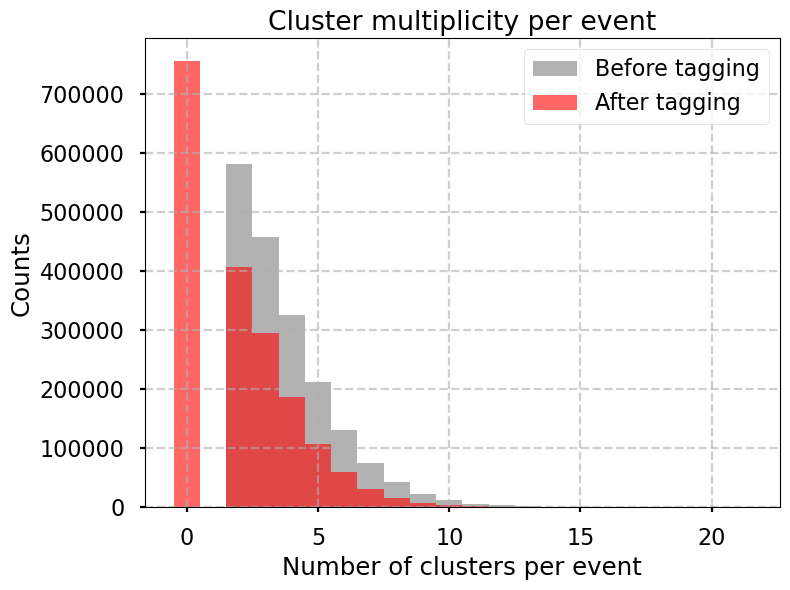

In [2]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb

# ======================
# Constants
# ======================
m_e = 0.000511
m_p = 0.938
m_pi = 0.135
E_beam = 10.537  # GeV

# Beam 4-vector
p4_ein = np.array([E_beam, 0.0, 0.0, E_beam])

# ======================
# Load branches (apply 2-cluster requirement)
# ======================
has_two_clust = ak.num(branches["NPS.cal.clusE"]) >= 2

px_e = ak.to_numpy(branches["H.gtr.px"][has_two_clust])
py_e = ak.to_numpy(branches["H.gtr.py"][has_two_clust])
pz_e = ak.to_numpy(branches["H.gtr.pz"][has_two_clust])
Ee   = ak.to_numpy(branches["H.gtr.p"][has_two_clust])

clusE = branches["NPS.cal.clusE"][has_two_clust]
clusX = branches["NPS.cal.clusX"][has_two_clust]
clusY = branches["NPS.cal.clusY"][has_two_clust]

# ======================
# Numba helper functions
# ======================
@nb.njit
def rotate_nps_to_hall(px, py, pz, theta_deg=-17.51):
    theta = np.deg2rad(theta_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    px_rot = cos_t * px + sin_t * pz
    pz_rot = -sin_t * px + cos_t * pz
    return px_rot, py, pz_rot

@nb.njit
def get_photon_4vectors(E, x, y, z=407.0):
    n = len(E)
    arr = np.zeros((n, 4))
    for i in range(n):
        norm = np.sqrt(x[i]**2 + y[i]**2 + z**2)
        arr[i,0] = E[i]
        arr[i,1] = E[i]*x[i]/norm
        arr[i,2] = E[i]*y[i]/norm
        arr[i,3] = E[i]*z/norm
    return arr

@nb.njit
def compute_Q2_vec(px_e, py_e, pz_e, Ee):
    n = len(Ee)
    Q2_arr = np.zeros(n)
    for i in range(n):
        q0 = E_beam - Ee[i]
        q1 = -px_e[i]
        q2 = -py_e[i]
        q3 = E_beam - pz_e[i]
        Q2_arr[i] = -(q0*q0 - (q1*q1 + q2*q2 + q3*q3))
    return Q2_arr

@nb.njit
def inequality_pass_vec(E_pi_arr, Ee_val, Q2_arr):
    n = len(E_pi_arr)
    mask = np.zeros(n, dtype=np.bool_)
    for i in range(n):
        E_pi = E_pi_arr[i]
        Q2 = Q2_arr[i]
        E_p_scat = E_beam + m_p - Ee_val - E_pi
        lhs = 2*m_p**2 + m_pi**2 + Q2 + 2*(E_p_scat*E_pi - E_pi*m_p - E_p_scat*m_p)
        term1 = E_p_scat**2 - m_p**2
        term2 = E_pi**2 - m_pi**2
        if term1 > 0.0 and term2 > 0.0:
            rhs = np.sqrt(term1 * term2)
            mask[i] = lhs <= rhs
    return mask

# ======================
# Fully vectorized processing
# ======================
Epi_all, Q2_all, event_idx_all = [], [], []
Epi_pass, Q2_pass, event_idx_pass = [], [], []
cluster_tags = []

Q2_events = compute_Q2_vec(px_e, py_e, pz_e, Ee)

for i in range(len(Ee)):
    if Ee[i] < 3.5:
        cluster_tags.append(np.zeros(len(clusE[i]), dtype=bool))
        continue

    e_arr = np.array(clusE[i])
    x_arr = np.array(clusX[i])
    y_arr = np.array(clusY[i])
    nclus = len(e_arr)

    tags = np.zeros(nclus, dtype=bool)

    if nclus >= 2:
        # Generate all cluster pairs using numpy broadcasting
        idx1, idx2 = np.triu_indices(nclus, k=1)
        E1, E2 = e_arr[idx1], e_arr[idx2]
        X1, X2 = x_arr[idx1], x_arr[idx2]
        Y1, Y2 = y_arr[idx1], y_arr[idx2]

        # Photon 4-vectors
        ph1 = get_photon_4vectors(E1, X1, Y1)
        ph2 = get_photon_4vectors(E2, X2, Y2)

        # Rotate to hall frame
        p1x, p1y, p1z = rotate_nps_to_hall(ph1[:,1], ph1[:,2], ph1[:,3])
        p2x, p2y, p2z = rotate_nps_to_hall(ph2[:,1], ph2[:,2], ph2[:,3])

        p4_ph1 = np.stack([ph1[:,0], p1x, p1y, p1z], axis=1)
        p4_ph2 = np.stack([ph2[:,0], p2x, p2y, p2z], axis=1)

        p4_pi = p4_ph1 + p4_ph2
        E_pi_arr = p4_pi[:,0]

        # Q2 array for this event
        Q2_val = Q2_events[i]
        Q2_arr = np.full(len(E_pi_arr), Q2_val)

        # Store all candidates
        Epi_all.extend(E_pi_arr)
        Q2_all.extend(Q2_arr)
        event_idx_all.extend([i]*len(E_pi_arr))

        # Apply inequality in vectorized way
        mask = inequality_pass_vec(E_pi_arr, Ee[i], Q2_arr)
        Epi_pass.extend(E_pi_arr[mask])
        Q2_pass.extend(Q2_arr[mask])
        event_idx_pass.extend([i]*np.sum(mask))

        # Tag clusters
        for k, m in enumerate(mask):
            if m:
                tags[idx1[k]] = True
                tags[idx2[k]] = True

    cluster_tags.append(tags)

# ======================
# Convert to arrays
# ======================
Epi_all = np.array(Epi_all)
Q2_all = np.array(Q2_all)
event_idx_all = np.array(event_idx_all)

Epi_pass = np.array(Epi_pass)
Q2_pass = np.array(Q2_pass)
event_idx_pass = np.array(event_idx_pass)

# ======================
# Multiplicity plot
# ======================
n_before = np.array([len(ev) for ev in clusE])
n_after  = np.array([tags.sum() for tags in cluster_tags])

plt.figure(figsize=(8,6))
bins = np.arange(0, max(n_before.max(), n_after.max())+2) - 0.5
plt.hist(n_before, bins=bins, alpha=0.6, label="Before tagging", color="gray")
plt.hist(n_after, bins=bins, alpha=0.6, label="After tagging", color="red")
plt.xlabel("Number of clusters per event")
plt.ylabel("Counts")
plt.title("Cluster multiplicity per event")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("cluster_multiplicity.png", dpi=200)
plt.show()

# ======================
# Save results
# ======================
pd.DataFrame({"event": event_idx_all, "Epi": Epi_all, "Q2": Q2_all})\
    .to_csv("pion_energy_all_v2.csv", index=False)

pd.DataFrame({"event": event_idx_pass, "Epi": Epi_pass, "Q2": Q2_pass})\
    .to_csv("pion_energy_pass_v2.csv", index=False)

cluster_tag_df = []
for i, tags in enumerate(cluster_tags):
    for j, t in enumerate(tags):
        cluster_tag_df.append({
            "event": i,
            "cluster_index": j,
            "energy": float(clusE[i][j]),
            "x": float(clusX[i][j]),
            "y": float(clusY[i][j]),
            "tagged": bool(t)
        })

pd.DataFrame(cluster_tag_df).to_csv("cluster_tags_v2.csv", index=False)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")  # clean, consistent style
plt.rcParams.update({"font.size": 12})

# ======================
# Configuration
# ======================
DATA_DIR = Path("/home/ubuntu/nps_analysis/pi0_analysis")
FILE_ALL = DATA_DIR / "pion_energy_all_v2.csv"
FILE_PASS = DATA_DIR / "pion_energy_pass_v2.csv"

E_MAX = 3.0   # pion candidate energy cut (GeV)
Q2_MAX = 12.0 # Q² cut (GeV²)

# ======================
# Helper functions
# ======================
def load_and_clean(filepath):
    """Load CSV and drop invalid values."""
    df = pd.read_csv(filepath)
    return df.replace([np.inf, -np.inf], np.nan).dropna()

def compute_efficiency(values_all, values_pass, bins):
    """Return bin centers and efficiency array."""
    h_all, _ = np.histogram(values_all, bins)
    h_pass, _ = np.histogram(values_pass, bins)
    eff = h_pass / np.maximum(h_all, 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    return bin_centers, eff

def plot_efficiency(x, eff, xlabel, ylabel, title, fname, 
                    xlim=None, ylim=None, markersize=3, color="red"):
    """Generic efficiency plot with annotations and grid."""
    plt.figure(figsize=(8,6))
    plt.plot(x, eff, "o-", color=color, label="Efficiency", 
             markersize=markersize, linewidth=0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim: plt.xlim(*xlim)
    if ylim: plt.ylim(*ylim)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    plt.close()

# ======================
# Load data
# ======================
df_all  = load_and_clean(FILE_ALL)
df_pass = load_and_clean(FILE_PASS)

Epi_all, Epi_pass = df_all["Epi"].to_numpy(), df_pass["Epi"].to_numpy()
Q2_all,  Q2_pass  = df_all["Q2"].to_numpy(),  df_pass["Q2"].to_numpy()

# ======================
# Apply cuts
# ======================
mask_all  = (0 < Epi_all) & (Epi_all < E_MAX) & (0 < Q2_all) & (Q2_all < Q2_MAX)
mask_pass = (0 < Epi_pass) & (Epi_pass < E_MAX) & (0 < Q2_pass) & (Q2_pass < Q2_MAX)

Epi_all_cut, Epi_pass_cut = Epi_all[mask_all], Epi_pass[mask_pass]
Q2_all_cut,  Q2_pass_cut  = Q2_all[mask_all],  Q2_pass[mask_pass]

# ======================
# 1. Energy spectrum comparison
# ======================
plt.figure(figsize=(8,6))
plt.hist(Epi_all_cut, bins=120, alpha=0.4, label=f"All pairs (N={len(Epi_all_cut)})")
plt.hist(Epi_pass_cut, bins=120, alpha=0.7, label=f"Passing cut (N={len(Epi_pass_cut)})")
plt.xlabel("Pion candidate energy (GeV)")
plt.ylabel("Counts")
plt.legend()
plt.title("π⁰ candidate energy spectrum (<3 GeV)")
plt.tight_layout()
plt.savefig("pion_energy_spectrum_cut.png", dpi=200)
plt.show()
plt.close()

# ======================
# 2. Efficiency vs energy
# ======================
bins = np.linspace(0, 5, 100)
x, eff = compute_efficiency(Epi_all_cut, Epi_pass_cut, bins)
plot_efficiency(x, eff, "Pion candidate energy (GeV)", "Selection efficiency",
                "Inequality selection efficiency vs energy (<5 GeV)",
                "selection_efficiency.png", xlim=(0,3), ylim=(0,1.05))

# # Zoomed-in version (to see small deviations near 1)
# bins_zoom = np.linspace(0.7, 3, 50)
# x_zoom, eff_zoom = compute_efficiency(Epi_all_cut, Epi_pass_cut, bins_zoom)
# plot_efficiency(x_zoom, eff_zoom, "Pion candidate energy (GeV)", "Selection efficiency",
#                 "Efficiency vs energy (zoomed)", 
#                 "selection_efficiency_zoomed.png", 
#                 xlim=(0.8,3), ylim=(0.99,1.005), markersize=2)

# ======================
# 3. Cumulative distributions
# ======================
plt.figure(figsize=(8,6))
plt.hist(Epi_all_cut, bins=120, histtype="step", cumulative=True, density=True, label="All pairs")
plt.hist(Epi_pass_cut, bins=120, histtype="step", cumulative=True, density=True, label="Passing cut")
plt.xlabel("Pion candidate energy (GeV)")
plt.ylabel("Cumulative fraction")
plt.legend()
plt.title("Cumulative distributions (<3 GeV)")
plt.tight_layout()
plt.savefig("cumulative_energy_cut.png", dpi=200)
plt.show()
plt.close()

# ======================
# 4. Efficiency vs Q²
# ======================
bins_q2 = np.linspace(0, 8, 80)
x_q2, eff_q2 = compute_efficiency(Q2_all_cut, Q2_pass_cut, bins_q2)
plot_efficiency(x_q2, eff_q2, r"$Q^2$ (GeV$^2$)", "Selection efficiency",
                "Selection efficiency vs $Q^2$ (<3 GeV)",
                "efficiency_vs_q2.png")

# ======================
# 5. Q² vs Pion energy (2D heatmaps)
# ======================
def plot_hexbin(x, y, xlabel, ylabel, title, fname, cmap):
    plt.figure(figsize=(8,6))
    hb = plt.hexbin(x, y, gridsize=60, cmap=cmap, bins="log")
    plt.colorbar(hb, label="log10(N)")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    plt.close()

plot_hexbin(Epi_all_cut, Q2_all_cut, "Pion candidate energy (GeV)", r"$Q^2$ (GeV$^2$)",
            "Q² vs π⁰ candidate energy (all pairs, <3 GeV)", "Q2_vs_pion_all.png", "Blues")

plot_hexbin(Epi_pass_cut, Q2_pass_cut, "Pion candidate energy (GeV)", r"$Q^2$ (GeV$^2$)",
            "Q² vs π⁰ candidate energy (passing cut, <3 GeV)", "Q2_vs_pion_pass.png", "Reds")

# ======================
# 6. 2D Fraction passing heatmap
# ======================
E_bins = np.linspace(0,3,80)
Q_bins = np.linspace(0,12,80)
H_all, _, _  = np.histogram2d(Epi_all_cut, Q2_all_cut, bins=[E_bins, Q_bins])
H_pass, _, _ = np.histogram2d(Epi_pass_cut, Q2_pass_cut, bins=[E_bins, Q_bins])
fraction = H_pass / np.maximum(H_all, 1)

plt.figure(figsize=(8,6))
plt.imshow(fraction.T, origin="lower", aspect="auto",
           extent=[E_bins[0], E_bins[-1], Q_bins[0], Q_bins[-1]],
           cmap="viridis", vmin=0, vmax=1)
plt.colorbar(label="Fraction passing")
plt.xlabel("Pion candidate energy (GeV)")
plt.ylabel(r"$Q^2$ (GeV$^2$)")
plt.title("Fraction of events passing inequality")
plt.tight_layout()
plt.savefig("fraction_passing_2D.png", dpi=200)
plt.show()
plt.close()

# ======================
# Save efficiency data to CSV for reference
# ======================
pd.DataFrame({"E_bin_center": x, "Efficiency": eff}).to_csv("efficiency_vs_energy_v2.csv", index=False)
pd.DataFrame({"Q2_bin_center": x_q2, "Efficiency": eff_q2}).to_csv("efficiency_vs_Q2_v2.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/nps_analysis/pi0_analysis/pion_energy_all_v2.csv'